In [1]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy import signal
import IPython
import warnings
from pylab import *
warnings.filterwarnings("ignore")
%matplotlib inline

### Edoardo Vassallo
### S4965918

# Lofi e Serendipità
[![Alt text](res/img/lofi-girl-music.gif "lo-fi girl")](https://www.youtube.com/watch?v=jfKfPfyJRdk)

La serendipità è l'idea di trovare qualcosa involontariamente, o mentre si cerca qualcos'altro. La sottocategoria musicale del lofi è figlia di questa idea. Essa infatti cerca di replicare in registrazioni digitali moderne, alcuni dei difetti delle vecchie registrazioni analogiche su nastro o su disco (_lo-fi_ sta infatti per _low fidelity_). <br>

E perchè mai farebbero ciò? Questo è quello che questo notebook intende scoprire, analizzando tre filtri che sono utilizzati per replicare questi difetti, per comprendere i vantaggi artistici che portano alla traccia musicale.

## Metodi

Il seguente notbook cercherà di replicare i difetti sopracitati attraverso filtri di natura simile. Si mostrerà l'effetto di essi su un suono semplice, od un insieme di suoni semplici, e si mostrerà un esempio su un suono complesso, se ne è stato ritrovato uno. <br>

Il codice originale dei filtri mostrati era in codice MATLAB, esso è stato tradotto in codice Python


## Esperimenti

### Suono d'Esempio

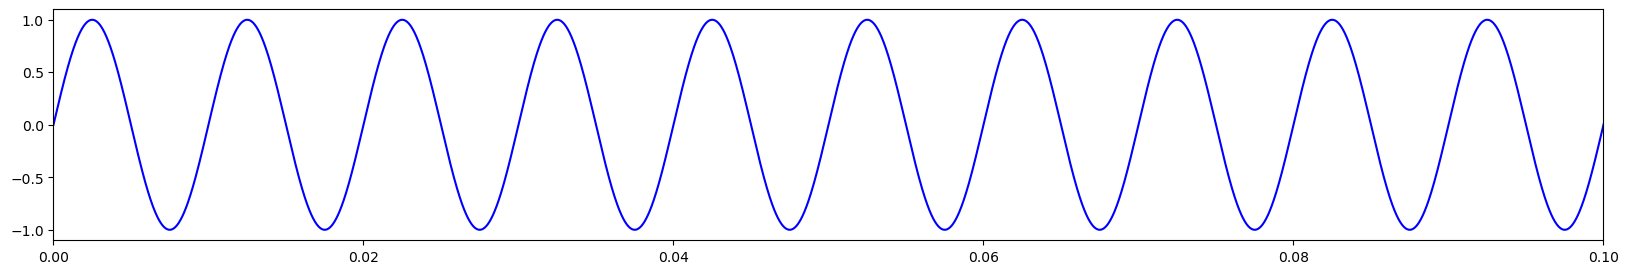

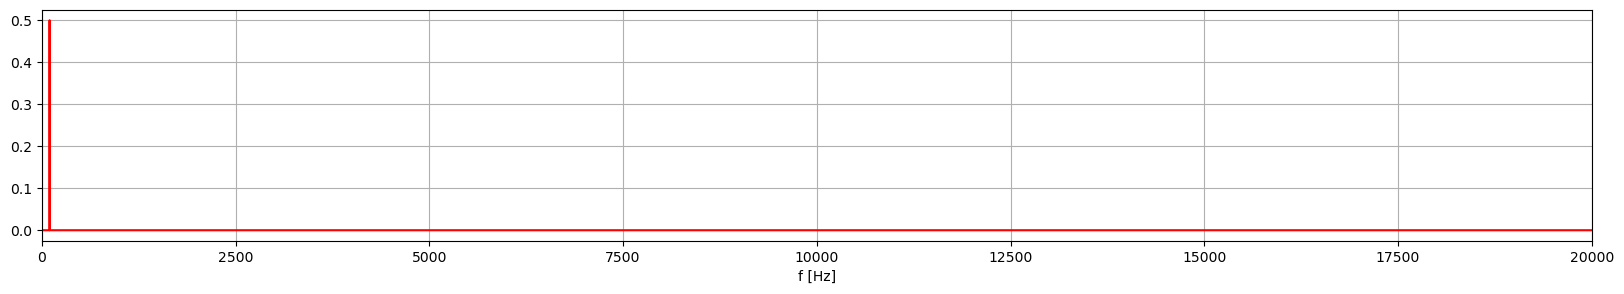

In [8]:
frequenza=100

fs = 44100 # sampling frequency
T = 4      # seconds
times = np.linspace(0, T, int(T*fs), endpoint=False) # time variable

test_sound = np.sin(2*np.pi*frequenza*times)    

N = len(test_sound) 
T_s = 1/fs 
t  = T_s * np.arange(N) 

# fourier
f  = fs/N * np.arange(N)
test_sound_fourier = np.fft.fft(test_sound)/N

# sound graph
plt.figure(figsize=(20, 3))
plt.xlim([0,0.1])
plt.plot(times, test_sound,'-b')

# fourier graph
plt.figure(figsize=(20, 3))
plt.plot(f[:N//2],np.abs(test_sound_fourier[:N//2]),'-r',label=r"$X(f)$")
plt.xlim([0,20e3])
plt.xlabel('f [Hz]')
plt.grid()

# hear sound
IPython.display.Audio(test_sound,rate=fs)

### Low End Head Bumps

In [2]:
# Low End Head Bump filter, as a peak filter 

# DA MODIFICARE

def peakfilt(x, Wc, Wb, G):
    # Applies a peak filter to the input signal x.
    # Wc is the normalized center frequency 0<Wc<1, i.e. 2*fc/fS.
    # Wb is the normalized bandwidth 0<Wb<1, i.e. 2*fb/fS.
    # G is the gain in dB.

    V0 = 10**(G/20)
    H0 = V0 - 1

    if G >= 0:
        c = (np.tan(np.pi * Wb / 2) - 1) / (np.tan(np.pi * Wb / 2) + 1)  # boost
    else:
        c = (np.tan(np.pi * Wb / 2) - V0) / (np.tan(np.pi * Wb / 2) + V0)  # cut

    d = -np.cos(np.pi * Wc)
    xh = np.array([0, 0])

    y = np.zeros_like(x)

    for n in range(len(x)):
        xh_new = x[n] - d * (1 - c) * xh[0] + c * xh[1]
        ap_y = -c * xh_new + d * (1 - c) * xh[0] + xh[1]
        xh = np.array([xh_new, xh[0]])
        y[n] = 0.5 * H0 * (x[n] - ap_y) + x[n]

    return y


### Tape Saturation

In [3]:
# Tape Saturation Filters

# Arctangent filter
def arctan_dist(input, alpha):
    # Sourced from: DA SCRIVERE
    # input : input signal
    # alpha : distortion amount (1-10)

    N = len(input)
    output = np.zeros_like(input)

    for n in range(N):
        output[n] = 2 * np.pi * np.arctan(alpha * input[n]) 
    return output

# Cubic filter
def cubic_dist(input, alpha):
    # Sourced from: DA SCRIVERE
    # input : input signal
    # alpha : distortion amount (0-1), 
    #         amplitude of 3rd harmonic

    N = len(input)
    output = np.zeros(N)

    for n in range(N):
        output[n] = input[n] - alpha * (1/3) * input[n]**3

    return output

# Exponential filter
def exp_dist(input, gain):
    # Sourced from: DA SCRIVERE
    # input : input signal
    # gain  : distortion amount (1-10), 

    N = len(input)
    output = np.zeros(N)

    for n in range(N):
        output[n] = np.sign(input[n]) * (1 - np.exp(-abs(gain * input[n])))

    return output


# Piece-Wise filter
def piecewise_dist(input):
    # Sourced from: DA SCRIVERE
    # input : input signal

    N = len(input)
    output = np.zeros_like(input)

    for n in range(N):
        if np.abs(input[n]) <= 1/3:
            output[n] = 2 * input[n]
        elif np.abs(input[n]) > 2/3:
            output[n] = np.sign(input[n])
        else:
            output[n] = np.sign(input[n]) * (3 - (2 - 3 * np.abs(input[n]))**2) / 3

    return output

# Parallel Distortion filter
def parallel_dist(input, dist_input, mix):
    # Sourced from: DA SCRIVERE
    # input : input signal
    # dist_input : distorted input
    # mix : blend percentage (0-100)

    # Convert mix to a linear gain value
    gain = mix / 100

    # Add together "wet/dry" signals
    output = gain * dist + (1 - gain) * input

    return output


In [ ]:
arc_filtered = arctan_dist(track, 3)
cub_filtered = cubic_dist(track, 0.3)
exp_filtered = exp_dist(track, 3)
pws_filtered = piecewise_dist(track)

### Wow and Flutters

In [4]:
# Wows and Flutter Filter, as a vibrato filter

def vibrato(x, SAMPLERATE, Modfreq, Width):
    ya_alt = 0
    Delay = Width  # basic delay of input sample in sec
    DELAY = round(Delay * SAMPLERATE)  # basic delay in # samples
    WIDTH = round(Width * SAMPLERATE)  # modulation width in # samples

    if WIDTH > DELAY:
        raise ValueError('Delay greater than basic delay !!!')

    MODFREQ = Modfreq / SAMPLERATE  # modulation frequency in # samples
    LEN = len(x)  # # of samples in WAV-file
    L = 2 + DELAY + WIDTH * 2  # length of the entire delay
    Delayline = np.zeros(L)  # memory allocation for delay
    y = np.zeros_like(x)  # memory allocation for output vector

    for n in range(LEN - 1):
        M = MODFREQ
        MOD = np.sin(M * 2 * np.pi * n)
        TAP = 1 + DELAY + WIDTH * MOD
        i = int(np.floor(TAP))
        frac = TAP - i
        Delayline = np.concatenate(([x[n]], Delayline[:L-1]))

        # Linear Interpolation
        y[n] = Delayline[i + 1] * frac + Delayline[i] * (1 - frac)

        # Allpass Interpolation
        # Effetto più forte
        # y[n] = (Delayline[i + 1] + (1 - frac) * Delayline[i] - (1 - frac) * ya_alt)
        # ya_alt = y[n]

        # Spline Interpolation 
        # Effetto più leggero
        # y[n] = (Delayline[i + 1] * frac**3 / 6
        #         + Delayline[i] * ((1 + frac)**3 - 4 * frac**3) / 6
        #         + Delayline[i - 1] * ((2 - frac)**3 - 4 * (1 - frac)**3) / 6
        #         + Delayline[i - 2] * (1 - frac)**3 / 6)

    return y


### Bit Crushing (DA DECIDERE)

In [ ]:
def bitReduct(input_signal, n_bits):
    # Determine the desired number of possible amplitude values
    amp_values = 2 ** n_bits

    # Shrink the full-scale signal (-1 to 1, peak-to-peak) to fit within a range of 0 to 1
    prep_input = 0.5 * input_signal + 0.5

    # Scale the signal to fit within the range of the possible values
    scale_input = amp_values * prep_input

    # Round the signal to the nearest integers
    round_input = np.round(scale_input)

    # Invert the scaling to fit the original range
    prep_out = round_input / amp_values

    # Fit in full-scale range
    out_signal = 2 * prep_out - 1

    return out_signal


## Fonti

#### DA FINIRE

### Bibliografia
1. [_DAFX: Digital Audio Effects, Second Edition._](https://onlinelibrary.wiley.com/doi/book/10.1002/9781119991298) <br>
    Edited by Udo Zölzer. © 2011 John Wiley & Sons, Ltd. <br>
    Published 2011 by John Wiley & Sons, Ltd. <br>
    ISBN: 978-0-470-66599-2

2. [_Analogue Tape Simulation in MATLAB_](https://ses.library.usyd.edu.au/bitstream/handle/2123/22615/DESC9115%20-%20Analogue%20Tape%20Simulation%20in%20MATLAB%20-%20Written%20Report.pdf?sequence=1&isAllowed=y) <br>
    Digital Audio Systems, DESC9115, 2020 <br>
    Master of Architectural Science (Audio and Acoustics) <br>
    Sydney School of Architecture, Design and Planning, The University of Sydney

### Sitografia

1. [_The Unpredictable Joys of Analog Recording_](https://www.endino.com/graphs/) <br>
    Jack Endino (2000-2006), www.endino.com
2. [_Explained: The Famous Lo-Fi Effect (And How To Make It)_](https://www.productionmusiclive.com/blogs/news/lofi-effect-explained) <br>
    Pelle Sundin, www.productionmusiclive.com
3. [_Tape Saturation - what is it and how do you use it_](https://samplecraze.com/tutorials/tape-saturation-what-is-it-and-how-do-you-use-it/) <br>
    www.samplecraze.com
### Video

1. [_Tape Saturation Explained_](https://www.youtube.com/watch?v=Fx9PY7AZL7M)<br>
    Short and Sweet Tutorials, Youtube
2. [_"What do wow and flutter sound like?"_](https://youtu.be/kCwRdrFtJuE?si=tqJqsC1hfC1dbH_U) <br>
    M. Zillch, Youtube